# Expense Fraud Detection 

This dataset consists of 56,000+ transactions and the objective is to build a binary classification model that will detect whether the transaction was a food expense transaction or not. The original variables in the dataset are the type of transaction, a description of this transaction, what country the transaction occured in, the amount, the amount on a daily basis, whether the transaction was a Receipt or Per Diem and the actual variable to be predicted, (Food vs Not Food).

# Part I:
    
# Data Cleaning 

The first step in this notebook preprocesses the data by checking for null values in all variables, looking at the distribution of variables to check for outliers, creating dummy variables for text features and binning them by count and adding those as new features. Also, a new feature is engineered, "# of days", so the model will potentially be able to better separate transactions from each other. Additionally, I impute null values using an advanced technique (SoftImpute) so the data distribution is consistent throughout the dataset. The dataset is then scaled using MinMax Scaler (0 to 1 scale) so that all features are evaluated on the same scale and are ready for model building regardless of which models are chosen. Lastly, the data is TfidfVectorized in high dimensional space using word vectors single count word vectors to create hundreds of new features based on type.

In [1]:
# Importing the dataset and looking at it's contents

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

Travel = pd.read_excel('Fraud Detection.xlsx')
Travel.head(1000)

,type,description,country,amount,amount_per_day,claim_type,is_food
0,Lunch when at NON client site,"Lunch at BBC Millbank, non-client site",United Kingdom,4.8230,4.8230,Receipt,food
1,Parking,NaN,Brazil,2.6558,2.6558,Receipt,non-food
2,Parking,NaN,Italy,1.1999,1.1999,Receipt,non-food
3,Other Expenses- Taxi,TAKSI,Turkey,15.9489,1.1392,Receipt,non-food
4,Onsite/offsite support - FB,NaN,China,13.4651,13.4651,Receipt,non-food
5,06 Meal allowance country,Forfait repas,France,105.5999,3.5199,Receipt,food
6,Late Sitting - Food,NaN,India,14.7942,0.4931,Receipt,food
7,01 Transports (Subscription),Abonnement fideli'ter mensuel aout mission SG,France,154.7999,5.1599,Receipt,non-food
8,Hotel abroad,Ohne Frühstück,United Kingdom,412.7399,137.5799,Receipt,non-food
9,"Hotel domestic 19% breakf,etc",Hotelfrühstück,Germany,5.9999,2.9999,Receipt,non-food


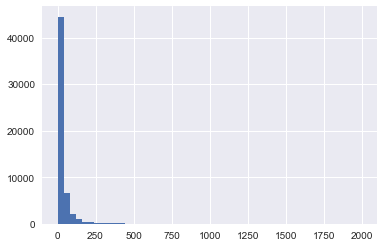

In [2]:
# The Amount Per Day distribution shows that most of the total expenses on a transaction basis
# was relatively low but there are some outliers as expected. The distribution is very
# similarly shaped to the right tail side of a normal distribution. There is no need to remove
# outliers here because it does not seem possible to tell that the outliers are obviously
# wrong and could potentially represent true outliers.

xmin = 0
xmax = 2000
Travel.amount_per_day.hist(bins=50, range=[xmin,xmax])

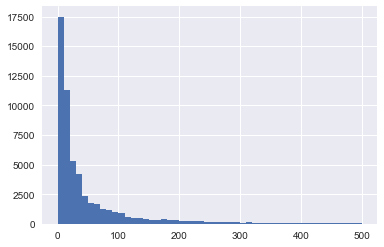

In [3]:
# The Total Travel Amount distribution shows that most of the total expenses on a transaction
# basis is relatively low but there are some outliers. The relationship is very similar to the
# one seen above where the Amount Per Day distribution is shown. This is very logical
# considering that they are highly correlated variables.

xmin = 0
xmax = 500
Travel.amount.hist(bins=50, range=[xmin,xmax])

In [4]:
# Here I take a look at the Travel outliers to see if there are any things that immediately
# stand out. No obvious reason seems to stand out for outliers of Amount above 300 to consider
# removing any such values after inspecting this. 

Travel.ix[(Travel['amount']>300)].head(2)

,type,description,country,amount,amount_per_day,claim_type,is_food
8,Hotel abroad,Ohne Frühstück,United Kingdom,412.7399,137.5799,Receipt,non-food
17,Airfare abroad,Berlin-Brüssel-Berlin,Belgium,557.1799,557.1799,Receipt,non-food


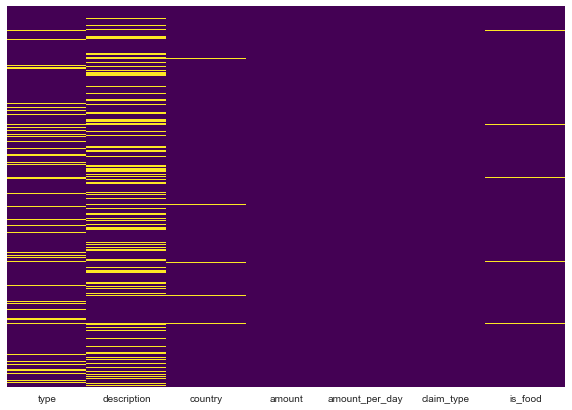

In [5]:
# Create a heatmap, to check for null values in the dataset and to get a general feel for 
# where the null values are and a rough idea of their count for all the features

plt.figure(figsize=(10,7))
sns.heatmap(Travel.isnull(),yticklabels=False, cbar=False, cmap='viridis')

In [6]:
# Check value counts for isnull type to get a more precise picture of above visualization

Travel['type'].isnull().value_counts()

False    48712
True      7499
Name: type, dtype: int64

In [7]:
# Check value counts for isnull description to get a more precise picture of above visualization

Travel['description'].isnull().value_counts()

False    43116
True     13095
Name: description, dtype: int64

In [8]:
# Dummifying the countries variable and removing 1 of the 107 features due to complete 
# information in the n-1 features

Countries_Dummified= pd.get_dummies(Travel.country)
del Countries_Dummified['Argentina']
Countries_Dummified.head(2)

,Australia,Austria,Azerbaijan,Bahamas,Barbados,Belgium,Benin,Bosnia and Herzegovina,Brazil,Brunei,...,Tunisia,Turkey,Turkmenistan,Uganda,United Arab Emirates,United Kingdom,United States of America,Uruguay,Venezuela,Vietnam
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Count how many Type Count categories and store that as a new variable to add afterwards
# as a new feature to the original dataframe
Travel_Type_Count = Travel.groupby('type').size().sort_values(ascending=False) \
  .reset_index(name='Type_Count')
    
Travel_Type_Count.head(5)

,type,Type_Count
0,Taxi,2440
1,Rail,2136
2,Parking/Tolls/Cong Charge,1914
3,06 Lunch,1765
4,Lunch when at NON client site,1764


In [10]:
# Merge the above variable with original dataframe. The purpose of this is to afterwards create
# a binning of this variable by count of how often they appear in the dataset as an additional
# feature to later build use to build a model.

Travel_Type = pd.merge(Travel,Travel_Type_Count, how = 'left', on = 'type')
Travel_Type.head(5)

,type,description,country,amount,amount_per_day,claim_type,is_food,Type_Count
0,Lunch when at NON client site,"Lunch at BBC Millbank, non-client site",United Kingdom,4.8230,4.8230,Receipt,food,1764.0
1,Parking,NaN,Brazil,2.6558,2.6558,Receipt,non-food,1011.0
2,Parking,NaN,Italy,1.1999,1.1999,Receipt,non-food,1011.0
3,Other Expenses- Taxi,TAKSI,Turkey,15.9489,1.1392,Receipt,non-food,96.0
4,Onsite/offsite support - FB,NaN,China,13.4651,13.4651,Receipt,non-food,46.0


In [11]:
# Count how many Description Count categories and store that as a new variable to add afterwards
# as a new feature to the original dataframe to later bin and include in the model as a new variable
Travel_Description_Count  = Travel.groupby('description').size().sort_values(ascending=False) \
  .reset_index(name='Description_Count')
Travel_Description_Count.head(5)

,description,Description_Count
0,Meals for 1 day trip,996
1,Lunch,811
2,Parking,507
3,Taxi,374
4,Meals for 2 day trip,334


In [12]:
# Merge the description variable with original dataframe. The purpose of this is to afterwards create
# a binning of this variable by count of how often they appear in the dataset as an additional
# feature to later build the model on
Travel_Type_description = pd.merge(Travel_Type,Travel_Description_Count, how = 'left', on = 'description')
Travel_Type_description.head(5)

,type,description,country,amount,amount_per_day,claim_type,is_food,Type_Count,Description_Count
0,Lunch when at NON client site,"Lunch at BBC Millbank, non-client site",United Kingdom,4.8230,4.8230,Receipt,food,1764.0,4.0
1,Parking,NaN,Brazil,2.6558,2.6558,Receipt,non-food,1011.0,NaN
2,Parking,NaN,Italy,1.1999,1.1999,Receipt,non-food,1011.0,NaN
3,Other Expenses- Taxi,TAKSI,Turkey,15.9489,1.1392,Receipt,non-food,96.0,8.0
4,Onsite/offsite support - FB,NaN,China,13.4651,13.4651,Receipt,non-food,46.0,NaN


In [13]:
# Count how many Description Count categories and store that as a new variable to add afterwards
# as a new feature to the original dataframe.
Travel_Country_Count  = Travel.groupby('country').size().sort_values(ascending=False) \
  .reset_index(name='Country_Count')    
Travel_Country_Count.head(5)

,country,Country_Count
0,United Kingdom,12898
1,France,10207
2,Flat rate,6429
3,Germany,5838
4,United States of America,2852


In [14]:
# Merge the description variable with original dataframe. The purpose of this is to afterwards create
# a binning of this variable by count of how often they appear in the dataset as an additional
# feature to later build the model.
Travel_Type_description_country = pd.merge(Travel_Type_description,Travel_Country_Count, how = 'left', on = 'country')
Travel_Type_description_country.head(5)

,type,description,country,amount,amount_per_day,claim_type,is_food,Type_Count,Description_Count,Country_Count
0,Lunch when at NON client site,"Lunch at BBC Millbank, non-client site",United Kingdom,4.8230,4.8230,Receipt,food,1764.0,4.0,12898.0
1,Parking,NaN,Brazil,2.6558,2.6558,Receipt,non-food,1011.0,NaN,676.0
2,Parking,NaN,Italy,1.1999,1.1999,Receipt,non-food,1011.0,NaN,1018.0
3,Other Expenses- Taxi,TAKSI,Turkey,15.9489,1.1392,Receipt,non-food,96.0,8.0,575.0
4,Onsite/offsite support - FB,NaN,China,13.4651,13.4651,Receipt,non-food,46.0,NaN,2320.0


In [15]:
#Feature engineering a new feature called # of days in order to create a more powerful
#predictive model. This seems like a natural feature to create given that the total expenditure
#is given and the daily expenditure, this will show how many days someone was on a business 
#trip which can potentially be insightfull.
Travel_Type_description_country['Number_of_days'] = Travel_Type_description_country['amount']/Travel_Type_description_country['amount_per_day']
Travel_Type_description_country.head(5)

,type,description,country,amount,amount_per_day,claim_type,is_food,Type_Count,Description_Count,Country_Count,Number_of_days
0,Lunch when at NON client site,"Lunch at BBC Millbank, non-client site",United Kingdom,4.8230,4.8230,Receipt,food,1764.0,4.0,12898.0,1.000000
1,Parking,NaN,Brazil,2.6558,2.6558,Receipt,non-food,1011.0,NaN,676.0,1.000000
2,Parking,NaN,Italy,1.1999,1.1999,Receipt,non-food,1011.0,NaN,1018.0,1.000000
3,Other Expenses- Taxi,TAKSI,Turkey,15.9489,1.1392,Receipt,non-food,96.0,8.0,575.0,14.000088
4,Onsite/offsite support - FB,NaN,China,13.4651,13.4651,Receipt,non-food,46.0,NaN,2320.0,1.000000


In [16]:
# This is the setup for TfidfVectorizer
# Fill NaN with arbitrary text in order to not get coding error with NaN  
Travel['description'] = Travel['description'].fillna('hi')
Travel.head(5)

,type,description,country,amount,amount_per_day,claim_type,is_food
0,Lunch when at NON client site,"Lunch at BBC Millbank, non-client site",United Kingdom,4.8230,4.8230,Receipt,food
1,Parking,hi,Brazil,2.6558,2.6558,Receipt,non-food
2,Parking,hi,Italy,1.1999,1.1999,Receipt,non-food
3,Other Expenses- Taxi,TAKSI,Turkey,15.9489,1.1392,Receipt,non-food
4,Onsite/offsite support - FB,hi,China,13.4651,13.4651,Receipt,non-food


In [17]:
# This is the setup for TfidfVectorizer
# Fill NaN with arbitrary text in order to not get coding error with NaN  
Travel_Type_description_country['type'] = Travel_Type_description_country['type'].fillna('hi')
Travel_Type_description_country.head(5)

,type,description,country,amount,amount_per_day,claim_type,is_food,Type_Count,Description_Count,Country_Count,Number_of_days
0,Lunch when at NON client site,"Lunch at BBC Millbank, non-client site",United Kingdom,4.8230,4.8230,Receipt,food,1764.0,4.0,12898.0,1.000000
1,Parking,NaN,Brazil,2.6558,2.6558,Receipt,non-food,1011.0,NaN,676.0,1.000000
2,Parking,NaN,Italy,1.1999,1.1999,Receipt,non-food,1011.0,NaN,1018.0,1.000000
3,Other Expenses- Taxi,TAKSI,Turkey,15.9489,1.1392,Receipt,non-food,96.0,8.0,575.0,14.000088
4,Onsite/offsite support - FB,NaN,China,13.4651,13.4651,Receipt,non-food,46.0,NaN,2320.0,1.000000


In [18]:
# Creating a list that can be vectorized

Counter = Travel_Type_description_country['type'].values.tolist()
Counter

[u'Lunch when  at NON client site',
 u'Parking',
 u'Parking',
 u'Other Expenses-  Taxi',
 u'Onsite/offsite support - FB',
 u'06 Meal allowance country',
 u'Late Sitting - Food',
 u'01 Transports (Subscription)',
 u'Hotel  abroad',
 u'Hotel  domestic 19% breakf,etc',
 u'Taxi',
 u'Rail',
 'hi',
 u'others 19 %',
 u'Telephone - Mobile',
 u'Hotel domestic 7% (accomad.)',
 'hi',
 u'Airfare abroad',
 u'Underground',
 u'01 Transports (occasional)',
 u'01 Transports (Subscription)',
 'hi',
 'hi',
 u'Hotel domestic 7% (accomad.)',
 u'Parking/Tolls/Cong Charge',
 'hi',
 u'06 Lnch+Dnnr Paris (cumulated)',
 u'09 Pers. Internet  - Home work',
 u'Petrol Domestic - not TaxD',
 u'FOREIGN OTHER EXPENSE',
 u'Parking',
 u'Late Sitting - Food',
 u'Rail',
 u'Laundry',
 u'Train 0 %',
 u'02 Taxi',
 u'Taxi',
 u'09 Pers. Internet  - Home work',
 u'Hotel  domestic 19% breakf,etc',
 u'06 Lunch',
 u'Rail',
 u'Hotel',
 u'06 Dinner - Drink (20% VAT)',
 u'Lunch when  at NON client site',
 u'07 Hotel Paris / Sophia',


In [19]:
#Creating a sparse matrix in high dimensional space and compute the CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
vec.fit_transform(Counter)

<56211x641 sparse matrix of type '<type 'numpy.int64'>'
	with 138526 stored elements in Compressed Sparse Row format>

In [20]:
# Creating a dataframe with hundreds of features with TfDIF which is term frequency inverse
# document frequency. These are basically weighted sparse vectors of all the words in the type
# category. Some of these words are very commonly used in the dataset and every transaction
# will be compared to all the individual words and will be weighted by how much the word 
# appears in in that particular feature and inversely weighted how often it appears in the 
# whole dataset.

from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(Counter)
TfDif = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
TfDif.head(5)

,00,01,02,03,04,05,06,07,08,09,...,wireless,with,within,without,wkr,wo,work,working,xerox,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Create dummy variables for the claim type (include only one of two variables
# to avoid redundancy in the features), this is equivalent to one-hot encoding.
Claim = pd.get_dummies(Travel_Type_description_country.claim_type)
Claim.columns = ['Receipt', 'Per diem']
del Claim['Receipt']
Claim.head(5)

,Per diem
0,1
1,1
2,1
3,1
4,1


In [22]:
# Create dummy variables for the claim type (include only one of two variables to
# avoid redundancy), equivalent to one-hot encoding.
Food = pd.get_dummies(Travel_Type_description_country.is_food)
Food.columns = ['Food', 'Not_Food']
del Food['Not_Food']
Food.head(5)

,Food
0,1
1,0
2,0
3,0
4,0


In [23]:
# Concatenate the Travel dataframe to the Claim dataframe
Travel_Concate = pd.concat([Travel_Type_description_country, Claim], axis = 1)
del Travel_Concate['claim_type']
Travel_Concate.head(5)

,type,description,country,amount,amount_per_day,is_food,Type_Count,Description_Count,Country_Count,Number_of_days,Per diem
0,Lunch when at NON client site,"Lunch at BBC Millbank, non-client site",United Kingdom,4.8230,4.8230,food,1764.0,4.0,12898.0,1.000000,1
1,Parking,NaN,Brazil,2.6558,2.6558,non-food,1011.0,NaN,676.0,1.000000,1
2,Parking,NaN,Italy,1.1999,1.1999,non-food,1011.0,NaN,1018.0,1.000000,1
3,Other Expenses- Taxi,TAKSI,Turkey,15.9489,1.1392,non-food,96.0,8.0,575.0,14.000088,1
4,Onsite/offsite support - FB,NaN,China,13.4651,13.4651,non-food,46.0,NaN,2320.0,1.000000,1


In [24]:
# Create a dummy variable for Food and keep only the actual food to avoid redundancy
Travel_Concate = pd.concat([Travel_Concate,Food], axis = 1)
Travel_Concate.head(5)

,type,description,country,amount,amount_per_day,is_food,Type_Count,Description_Count,Country_Count,Number_of_days,Per diem,Food
0,Lunch when at NON client site,"Lunch at BBC Millbank, non-client site",United Kingdom,4.8230,4.8230,food,1764.0,4.0,12898.0,1.000000,1,1
1,Parking,NaN,Brazil,2.6558,2.6558,non-food,1011.0,NaN,676.0,1.000000,1,0
2,Parking,NaN,Italy,1.1999,1.1999,non-food,1011.0,NaN,1018.0,1.000000,1,0
3,Other Expenses- Taxi,TAKSI,Turkey,15.9489,1.1392,non-food,96.0,8.0,575.0,14.000088,1,0
4,Onsite/offsite support - FB,NaN,China,13.4651,13.4651,non-food,46.0,NaN,2320.0,1.000000,1,0


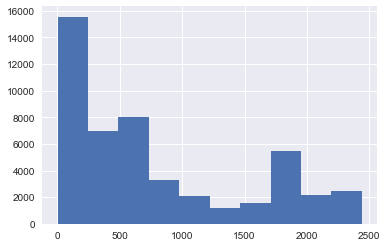

In [25]:
# Histogram to see how Type Count's are distributed to decide how many categories to bin the 
# histogram into

Travel_Concate['Type_Count'].hist()

In [26]:
# Break up into 10 bins based on the graph below. The purpose of this feature is to give
# higher numeric values transactions where the same Travel Count occurs more often.

bins = [0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]
group_names = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Travel_Concate['Travel_Count_Binned'] = pd.cut(Travel_Concate['Type_Count'], bins=bins, labels=group_names)
del Travel_Concate['Type_Count']
Travel_Concate.head(5)

,type,description,country,amount,amount_per_day,is_food,Description_Count,Country_Count,Number_of_days,Per diem,Food,Travel_Count_Binned
0,Lunch when at NON client site,"Lunch at BBC Millbank, non-client site",United Kingdom,4.8230,4.8230,food,4.0,12898.0,1.000000,1,1,8
1,Parking,NaN,Brazil,2.6558,2.6558,non-food,NaN,676.0,1.000000,1,0,5
2,Parking,NaN,Italy,1.1999,1.1999,non-food,NaN,1018.0,1.000000,1,0,5
3,Other Expenses- Taxi,TAKSI,Turkey,15.9489,1.1392,non-food,8.0,575.0,14.000088,1,0,1
4,Onsite/offsite support - FB,NaN,China,13.4651,13.4651,non-food,NaN,2320.0,1.000000,1,0,1


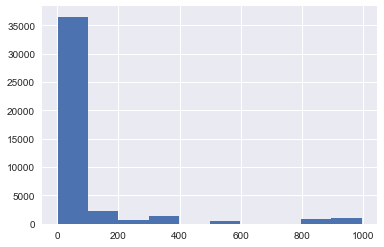

In [27]:
# Break up into 4 bins so the accuracy that is higher for Description counts will have higher
# values. The purpose of this feature is to give higher numeric values to transactions where
# the same Description Count occurs more often.

Travel_Concate.Description_Count.hist()

In [28]:
# Break up into 4 bins so the accuracy so that higher Description counts will have higher values
# The purpose of this feature is to give higher numeric values transactions where the same
# Description Count occurs more often

bins = [0, 250, 500, 750, 1000]
group_names = [1, 2, 3, 4]
Travel_Concate['Description_Count_Binned'] = pd.cut(Travel_Concate['Description_Count'], bins=bins, labels=group_names)
del Travel_Concate['Description_Count']
Travel_Concate.head(5)

,type,description,country,amount,amount_per_day,is_food,Country_Count,Number_of_days,Per diem,Food,Travel_Count_Binned,Description_Count_Binned
0,Lunch when at NON client site,"Lunch at BBC Millbank, non-client site",United Kingdom,4.8230,4.8230,food,12898.0,1.000000,1,1,8,1.0
1,Parking,NaN,Brazil,2.6558,2.6558,non-food,676.0,1.000000,1,0,5,NaN
2,Parking,NaN,Italy,1.1999,1.1999,non-food,1018.0,1.000000,1,0,5,NaN
3,Other Expenses- Taxi,TAKSI,Turkey,15.9489,1.1392,non-food,575.0,14.000088,1,0,1,1.0
4,Onsite/offsite support - FB,NaN,China,13.4651,13.4651,non-food,2320.0,1.000000,1,0,1,NaN


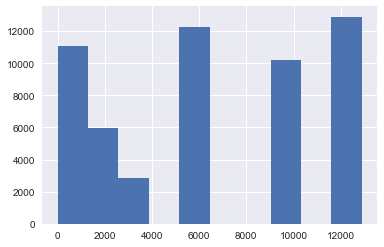

In [29]:
# Break up into 7 bins so the accuracy so that higher Country counts will have higher values.
# The purpose of this feature is to give higher numeric values transactions where the same
# Country Count occurs more often

Travel_Concate.Country_Count.hist()

In [30]:
# Break up into 7 bins so the accuracy so that higher Country counts will have higher values.
# The purpose of this feature is to give higher numeric values transactions where the same
# Country Count occurs more often

bins = [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000]
group_names = [1, 2, 3, 4, 5, 6, 7]
Travel_Concate['Country_Count_Binned'] = pd.cut(Travel_Concate['Country_Count'], bins=bins, labels=group_names)
del Travel_Concate['Country_Count']
Travel_Concate.head(5)

,type,description,country,amount,amount_per_day,is_food,Number_of_days,Per diem,Food,Travel_Count_Binned,Description_Count_Binned,Country_Count_Binned
0,Lunch when at NON client site,"Lunch at BBC Millbank, non-client site",United Kingdom,4.8230,4.8230,food,1.000000,1,1,8,1.0,7
1,Parking,NaN,Brazil,2.6558,2.6558,non-food,1.000000,1,0,5,NaN,1
2,Parking,NaN,Italy,1.1999,1.1999,non-food,1.000000,1,0,5,NaN,1
3,Other Expenses- Taxi,TAKSI,Turkey,15.9489,1.1392,non-food,14.000088,1,0,1,1.0,1
4,Onsite/offsite support - FB,NaN,China,13.4651,13.4651,non-food,1.000000,1,0,1,NaN,2


In [31]:
Travel_Concate.dtypes

type                          object
description                   object
country                       object
amount                       float64
amount_per_day               float64
is_food                       object
Number_of_days               float64
Per diem                       uint8
Food                           uint8
Travel_Count_Binned         category
Description_Count_Binned    category
Country_Count_Binned        category
dtype: object

In [32]:
# Convert all previous columns treated as strings to numeric form in order to properly 
# Scale as the scaling only takes numeric values.
Travel_Concate.Travel_Count_Binned   = [float(x) if (type(x) == str) else x for x in Travel_Concate['Travel_Count_Binned']]
Travel_Concate.Description_Count_Binned  = [float(x) if (type(x) == str) else x for x in Travel_Concate['Description_Count_Binned']]
Travel_Concate.Country_Count_Binned  = [float(x) if (type(x) == str) else x for x in Travel_Concate['Country_Count_Binned']]
Travel_Concate.dtypes

type                         object
description                  object
country                      object
amount                      float64
amount_per_day              float64
is_food                      object
Number_of_days              float64
Per diem                      uint8
Food                          uint8
Travel_Count_Binned         float64
Description_Count_Binned    float64
Country_Count_Binned        float64
dtype: object

In [33]:
del Travel_Concate['type']
del Travel_Concate['description']
del Travel_Concate['country']
del Travel_Concate['is_food']
Travel_Concate.dtypes

amount                      float64
amount_per_day              float64
Number_of_days              float64
Per diem                      uint8
Food                          uint8
Travel_Count_Binned         float64
Description_Count_Binned    float64
Country_Count_Binned        float64
dtype: object

In [34]:
# Selecting features for preprocessing
Travel_Concate = Travel_Concate[['amount', 'amount_per_day','Number_of_days','Travel_Count_Binned','Description_Count_Binned','Country_Count_Binned']]
Travel_Concate.head(5)

,amount,amount_per_day,Number_of_days,Travel_Count_Binned,Description_Count_Binned,Country_Count_Binned
0,4.8230,4.8230,1.000000,8.0,1.0,7.0
1,2.6558,2.6558,1.000000,5.0,NaN,1.0
2,1.1999,1.1999,1.000000,5.0,NaN,1.0
3,15.9489,1.1392,14.000088,1.0,1.0,1.0
4,13.4651,13.4651,1.000000,1.0,NaN,2.0


In [35]:
# Normalized the Data before imputing null values using Min Max Scaler (0 to 1 scale)
Travel_Concate_normalized=(Travel_Concate-Travel_Concate.min())/(Travel_Concate.max()-Travel_Concate.min())
Travel_Concate_normalized.head(5)

,amount,amount_per_day,Number_of_days,Travel_Count_Binned,Description_Count_Binned,Country_Count_Binned
0,0.261165,0.272008,0.000000,0.777778,0.0,1.000000
1,0.261014,0.271850,0.000000,0.444444,NaN,0.000000
2,0.260912,0.271744,0.000000,0.444444,NaN,0.000000
3,0.261943,0.271740,0.011844,0.000000,0.0,0.000000
4,0.261769,0.272637,0.000000,0.000000,NaN,0.166667


In [36]:
Travel_Concate_normalized = pd.concat([Travel_Concate_normalized,Countries_Dummified], axis=1)
Travel_Concate_normalized.head(5)

,amount,amount_per_day,Number_of_days,Travel_Count_Binned,Description_Count_Binned,Country_Count_Binned,Australia,Austria,Azerbaijan,Bahamas,...,Tunisia,Turkey,Turkmenistan,Uganda,United Arab Emirates,United Kingdom,United States of America,Uruguay,Venezuela,Vietnam
0,0.261165,0.272008,0.000000,0.777778,0.0,1.000000,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.261014,0.271850,0.000000,0.444444,NaN,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.260912,0.271744,0.000000,0.444444,NaN,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.261943,0.271740,0.011844,0.000000,0.0,0.000000,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.261769,0.272637,0.000000,0.000000,NaN,0.166667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Imputed using SoftImpute, a state of the art algorithm for imputation from a fairly recent
# research paper: Matrix completion by iterative soft thresholding of SVD decompositions by
# Mazumder et. al. because it keeps better structure within the dataset then a simple mean
# computation that does not preserve how well the features are distributed.

from fancyimpute import  SoftImpute
df_numeric = Travel_Concate_normalized.select_dtypes(include=[np.float]).as_matrix()
X_filled_softimpute = pd.DataFrame(SoftImpute().complete(df_numeric))
X_filled_softimpute.columns = ['amount','amount_per_day','Number_of_days','Travel_Count_Binned','Description_Count_Binned','Country_Count_Binned']
X_filled_softimpute

[SoftImpute] Max Singular Value of X_init = 182.608614
[SoftImpute] Iter 1: observed MAE=0.009711 rank=5
[SoftImpute] Iter 2: observed MAE=0.009719 rank=5
[SoftImpute] Iter 3: observed MAE=0.009726 rank=5
[SoftImpute] Iter 4: observed MAE=0.009733 rank=5
[SoftImpute] Iter 5: observed MAE=0.009739 rank=5
[SoftImpute] Iter 6: observed MAE=0.009744 rank=5
[SoftImpute] Iter 7: observed MAE=0.009750 rank=5
[SoftImpute] Iter 8: observed MAE=0.009754 rank=5
[SoftImpute] Iter 9: observed MAE=0.009759 rank=5
[SoftImpute] Iter 10: observed MAE=0.009763 rank=5
[SoftImpute] Iter 11: observed MAE=0.009767 rank=5
[SoftImpute] Iter 12: observed MAE=0.009770 rank=5
[SoftImpute] Iter 13: observed MAE=0.009774 rank=5
[SoftImpute] Iter 14: observed MAE=0.009777 rank=5
[SoftImpute] Iter 15: observed MAE=0.009780 rank=5
[SoftImpute] Iter 16: observed MAE=0.009782 rank=5
[SoftImpute] Iter 17: observed MAE=0.009785 rank=5
[SoftImpute] Iter 18: observed MAE=0.009787 rank=5
[SoftImpute] Iter 19: observed MAE=0

,amount,amount_per_day,Number_of_days,Travel_Count_Binned,Description_Count_Binned,Country_Count_Binned
0,0.261165,0.272008,0.000000,0.777778,0.000000,1.000000
1,0.261014,0.271850,0.000000,0.444444,0.040249,0.000000
2,0.260912,0.271744,0.000000,0.444444,0.040242,0.000000
3,0.261943,0.271740,0.011844,0.000000,0.000000,0.000000
4,0.261769,0.272637,0.000000,0.000000,0.020968,0.166667
5,0.268207,0.271913,0.026422,0.333333,0.000000,0.833333
6,0.261862,0.271693,0.026423,0.000000,0.016558,0.000000
7,0.271645,0.272033,0.026422,0.222222,0.000000,0.833333
8,0.289668,0.281670,0.001822,0.000000,0.000000,1.000000
9,0.261247,0.271875,0.000911,0.222222,0.000000,0.333333


In [38]:
# Concatenate the Travel dataframe to the Claim and Food dataframe
Travel_Concate = pd.concat([X_filled_softimpute, Claim, Food], axis = 1)
Travel_Concate.head(5)

,amount,amount_per_day,Number_of_days,Travel_Count_Binned,Description_Count_Binned,Country_Count_Binned,Per diem,Food
0,0.261165,0.272008,0.000000,0.777778,0.000000,1.000000,1,1
1,0.261014,0.271850,0.000000,0.444444,0.040249,0.000000,1,0
2,0.260912,0.271744,0.000000,0.444444,0.040242,0.000000,1,0
3,0.261943,0.271740,0.011844,0.000000,0.000000,0.000000,1,0
4,0.261769,0.272637,0.000000,0.000000,0.020968,0.166667,1,0


In [39]:
# Split dataset into Train and Test Features
X = Travel_Concate[['amount','amount_per_day','Number_of_days','Travel_Count_Binned','Description_Count_Binned','Country_Count_Binned']]
y = Travel_Concate["Food"]

In [40]:
# Split dataset into Train and Test Features continuation

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

/Users/Misha/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


 1) Travel_Count_Binned            0.243668
 2) amount_per_day                 0.209293
 3) amount                         0.200790
 4) Description_Count_Binned       0.157414
 5) Country_Count_Binned           0.142574
 6) Number_of_days                 0.046260


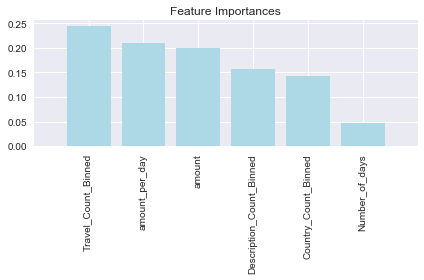

In [41]:
# Feature ranking before all the high dimensional space features from TfDiFVectorizer and 
# Country Counts get factored in since each of them individually can not be too significant.

from sklearn.ensemble import RandomForestClassifier
feat_labels = X.columns[:]
forest = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]): 
    print ("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]],importances[indices[f]])) 
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices],color='lightblue', align='center')     
plt.xticks(range(X_train.shape[1]),feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()


In [42]:
# Combination of original dataframe with TfDIF
Combined = pd.concat([Travel_Concate,TfDif,Countries_Dummified], axis= 1)
Combined.head(5)

,amount,amount_per_day,Number_of_days,Travel_Count_Binned,Description_Count_Binned,Country_Count_Binned,Per diem,Food,00,01,...,Tunisia,Turkey,Turkmenistan,Uganda,United Arab Emirates,United Kingdom,United States of America,Uruguay,Venezuela,Vietnam
0,0.261165,0.272008,0.000000,0.777778,0.000000,1.000000,1,1,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,0.261014,0.271850,0.000000,0.444444,0.040249,0.000000,1,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.260912,0.271744,0.000000,0.444444,0.040242,0.000000,1,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.261943,0.271740,0.011844,0.000000,0.000000,0.000000,1,0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
4,0.261769,0.272637,0.000000,0.000000,0.020968,0.166667,1,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# Extracting all the features into a seperate dataframe in order to later feed into the 
# machine learning model.

X = Combined.loc[:, Combined.columns != 'Food']
X.head(5)

,amount,amount_per_day,Number_of_days,Travel_Count_Binned,Description_Count_Binned,Country_Count_Binned,Per diem,00,01,02,...,Tunisia,Turkey,Turkmenistan,Uganda,United Arab Emirates,United Kingdom,United States of America,Uruguay,Venezuela,Vietnam
0,0.261165,0.272008,0.000000,0.777778,0.000000,1.000000,1,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,0.261014,0.271850,0.000000,0.444444,0.040249,0.000000,1,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.260912,0.271744,0.000000,0.444444,0.040242,0.000000,1,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.261943,0.271740,0.011844,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
4,0.261769,0.272637,0.000000,0.000000,0.020968,0.166667,1,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# extracting the target variable into a seperate dataframe to get ready for machine learning
# model.

y = Combined['Food'].to_frame()
y.head()

,Food
0,1
1,0
2,0
3,0
4,0


In [45]:
# calculate how many Food vs Non-Food items

Travel_Concate['Food'].value_counts()

0    40739
1    15472
Name: Food, dtype: int64

# Part II:

# Visualization

In the below visualization section, I will take a look at the features and try to identify 
interesting patterns to potentially investigate. First, I will look at the heatmap. From this, you can see all the interesting strong correlations between all variables that can give potential insights on which variables can make a difference and how in the model and gives opportunity for engineering new features. Afterwards, the strongly correlated relationships will be investigated further with scatterplots.

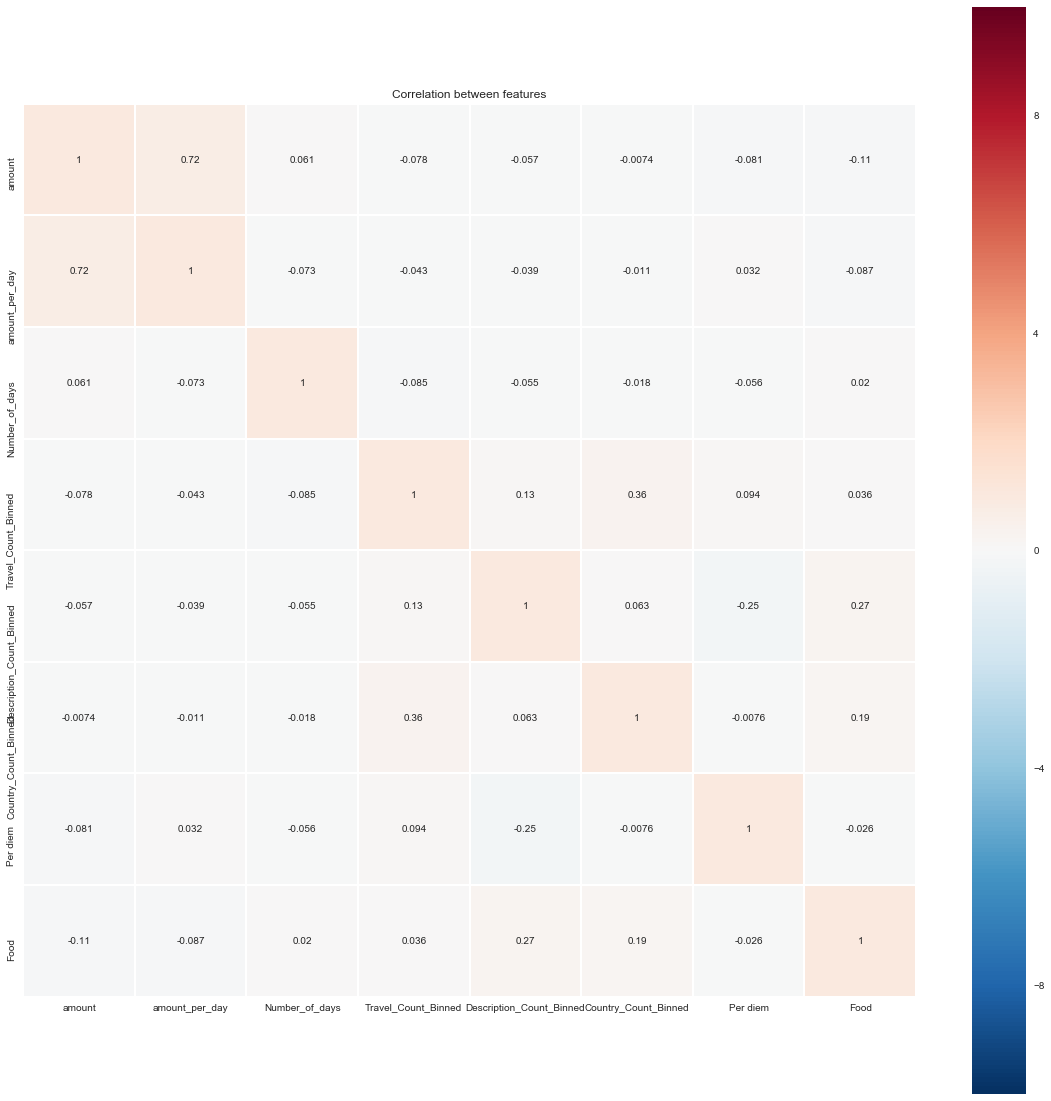

In [46]:
# plotting the heatmap showing the correlations bewetween all variables. You can see that the
# strongest relationship exists between Country_Count_Binned vs Food, Description_Count_Binned
# vs Food.

correlation = Travel_Concate.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation, vmax=10, square=True,annot=True,cmap=None, linewidths=1)

plt.title('Correlation between features')

Plot of description count binned vs food shows that there is a little more very low count 
non-Food items then Food items. Other than that, it is quiet difficult to distinguish between the Description Count with regards to Food and No Food.

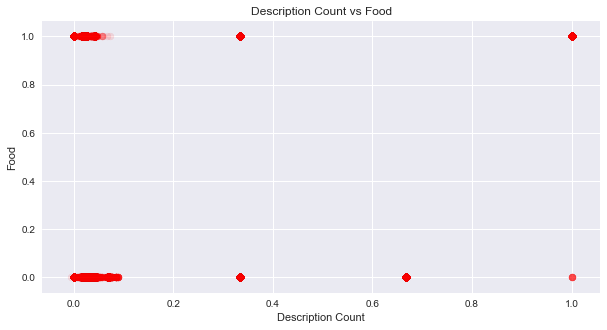

In [47]:
# plot of Description Count Binned vs Food
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Travel_Concate.Description_Count_Binned, Travel_Concate.Food, alpha=.1, color='r')
ax.set_title("Description Count vs Food")
ax.set_xlabel("Description Count")
ax.set_ylabel("Food")
plt.show()

There is a somewhat interesting relationship below. Country Count scaled in the ranges of 0.15 to 0.35 per the scatterplot below tend to have significantly higher Non-Food counts. However, due to the very specific and not general nature of the relationship in addition to the fact that the dataset already contains hundreds of features, I have decided not to create a new feature out of this insight.

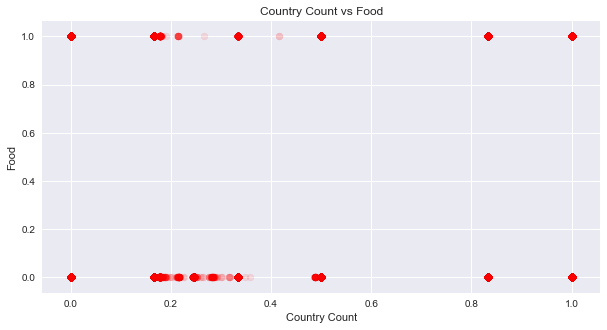

In [48]:
# plot of Country Count vs Food
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Travel_Concate.Country_Count_Binned, Travel_Concate.Food, alpha=.1, color='r')
ax.set_title("Country Count vs Food")
ax.set_xlabel("Country Count")
ax.set_ylabel("Food")
plt.show()

# Part III 

# Predictive Modeling

In this section we will first use a Feature Selection method (SelectKBest) to select only the top 10 features out of hundreds in order to significantly reduce dimensionality in order to prevent an overly noise model that overfits. This method determines which features to keep using p-values. Afterwards, I use Random Forests to fit and score (and cross-validate) the models using various Classification metrics including accuracy, ROC curve, specificity, sensitivity etc. Random Forests will than be tuned using various hyperparameters with Randomized Grid Search in an attempt to select the best possible model over the sample space. Randomized Grid Search is selected because regular Grid Search is computationally expensive if setting many different values and attributes to sample. The number of trees, number of features to subselect from an already feature selected model tend to be of the most importance when tuning a random forest. The reason for utilizing Random Forests is because this algorithm averages out many decision trees by majority voting and is one of the top performing machine learning algorithms from an accuracy standpoint.

In [49]:
# Baseline for variable to be predicted

from __future__ import division

Travel_Concate['Food'].value_counts()

print 40739/(40739+15472)
print 15472/(40739+15472)

0.724751383181
0.275248616819


In [50]:
# Selecting the top 10 features out of hundreds using a model that decides which features to 
# keep based on p-values.

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_new = SelectKBest(k=10).fit_transform(X, y)
X = pd.DataFrame(X_new)
X.head(5)

/Users/Misha/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.0,0.0,0.429927,0.336132,0.0,0.416635,0.0,0.427128,0.429927
1,0.040249,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,0.040242,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0.020968,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [51]:
y.head(5)

,Food
0,1
1,0
2,0
3,0
4,0


In [52]:
Final =pd.concat([X,y], axis = 1)
Final.head(5)

,0,1,2,3,4,5,6,7,8,9,Food
0,0.000000,0.0,0.0,0.429927,0.336132,0.0,0.416635,0.0,0.427128,0.429927,1
1,0.040249,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0
2,0.040242,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0
3,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0
4,0.020968,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0


In [53]:
# Create a new variable in order for the code in the model to properly execute.

y_arr = pd.DataFrame.as_matrix(y).ravel()
print y_arr
print y_arr.shape

[1 0 0 ..., 1 0 0]
(56211,)


In [54]:
# Split dataset into Train and Test Features continuation

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_arr, test_size=0.25, random_state=1)

# Random Forest Classifier

In [55]:
# Import Random Forests Classifier from Scikit Learn.
# Fit, predict with the algorithm and compute accuracy score

from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_jobs=2)
Forest = RF.fit(X,y_arr)
Y_pred=Forest.predict(X_test)

# Prediction Accuracy for Random Forests

from sklearn import metrics
print(metrics.accuracy_score(y_test, Y_pred))

0.943286131075


In [56]:
# Score for 10-fold Cross Validation for Random Forests Classifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(RF, X_train, y_train, cv=10, scoring= 'accuracy')
print(scores.mean())

0.934034164192


In [57]:
# Confusion matrix for Random Forests

confusion = metrics.confusion_matrix(y_test, Y_pred)
print confusion

[[10193    20]
 [  777  3063]]


In [58]:
# Classification Accuracy confirmation between manual calculation and formula for Random Forest

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, Y_pred))

0.943286131075
0.943286131075


In [59]:
# Misclassification Accuracy confirmation between manual calculation and formula for Random Forest
# This is also simply equal to 1-(Classification Accuracy calculated above).

print((FP + FN) / float(TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, Y_pred))

0.0567138689248
0.0567138689248


In [60]:
# This Represents the Sensitivity, the % out of True positives that were correctly evaluated as such.
# This is calculated for Random Forest Classifier

print(TP / float(TP + FN))
print(metrics.recall_score(y_test, Y_pred))

0.79765625
0.79765625


In [61]:
# This represents the Specificity, the % of total True negatives that were correctly identified as negatives.
# This is calculated for Random Forest Classifier

print(TN / float(TN + FP))

0.998041711544


In [62]:
# This represents the precision, what % of the values that were predicted to be positive actually are positive.
# This is calculated for Random Forest Classifier.

print(TP / float(TP + FP))
print(metrics.precision_score(y_test, Y_pred))

0.993512812196
0.993512812196


In [63]:
y_pred_prob_Random_Forest = RF.predict_proba(X_test)[:, 1]

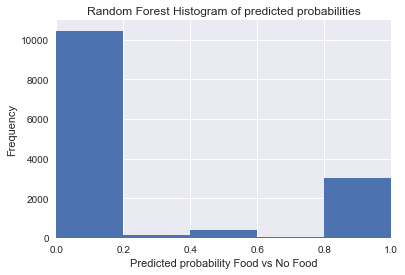

In [64]:
# histogram of predicted probabilities 
plt.hist(y_pred_prob_Random_Forest, bins=5)
plt.xlim(0, 1)
plt.title('Random Forest Histogram of predicted probabilities')
plt.xlabel('Predicted probability Food vs No Food')
plt.ylabel('Frequency')

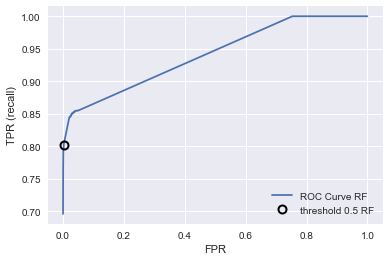

In [78]:
from sklearn.metrics import roc_curve, auc
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, Forest.predict_proba(X_test)[:,1])

plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")

plt.xlabel('FPR')
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_zero],tpr_rf[close_zero], 'o', markersize=8, label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)



# Support Vector Machines 

In [79]:
# Train, fit and predict with SVM

from sklearn import svm
Model=svm.SVC(kernel='rbf', C=10, gamma=0.1)
Model.fit(X,y_arr)
Y_pred=Model.predict(X_test)

In [80]:
# Cross validation score for SVM
scores = cross_val_score(Model, X_train, y_train, cv=10, scoring= 'accuracy')
print(scores.mean())

0.921225403926


In [81]:
# Evaluate SVM for accuracy

from sklearn import metrics
metrics.accuracy_score(y_test,Y_pred)

0.91852273535899809

In [82]:
# Confusion matrix for SVM

confusion = metrics.confusion_matrix(y_test, Y_pred)
print confusion

[[10087   126]
 [ 1019  2821]]


In [83]:
# Classification Accuracy confirmation between manual calculation and formula for SVM

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, Y_pred))

0.918522735359
0.918522735359


In [84]:
# Misclassification Accuracy confirmation between manual calculation and formula for SVM
# This is also simply equal to 1-(Classification Accuracy calculated above).

print((FP + FN) / float(TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, Y_pred))

0.081477264641
0.081477264641


In [85]:
# This Represents the Sensitivity, the % out of True positives that were correctly evaluated as such.
# This is calculated SVM

print(TP / float(TP + FN))
print(metrics.recall_score(y_test, Y_pred))

0.734635416667
0.734635416667


In [86]:
# This represents the Specificity, the % of total True negatives that were correctly identified as negatives.
# This is calculated for SVM

print(TN / float(TN + FP))

0.987662782728


In [87]:
# This represents the precision, what % of the values that were predicted to be positive actually are positive.
# This is calculated for SVM

print(TP / float(TP + FP))
print(metrics.precision_score(y_test, Y_pred))

0.957244655582
0.957244655582


In [88]:
# Misclassification Accuracy confirmation between manual calculation and formula for SVM
# This is also simply equal to 1-(Classification Accuracy calculated above).

print((FP + FN) / float(TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, Y_pred))

0.081477264641
0.081477264641


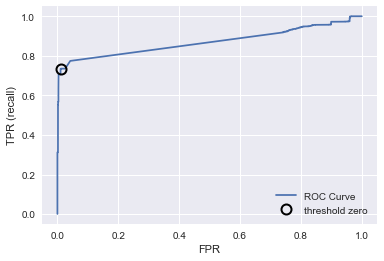

In [89]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, Model.decision_function(X_test))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel('FPR')
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)


# Part IV

# Conclusion

Firstly, a remark on what I would add if there would be more time to do the project. 
I would further experiment with TfIDFVectorizor in the sense that I would try to make it a more robust predictor by adding more features to its functionality like stop words and try it on the "description" variable in addition to "type" currently used. Additionally, I would attempt to create features like bigrams or trigrams which can perhaps be more informative then only 1 word. If that would be of limited help, I would attempt to manually further engineer the categorical variables "description" and "type" by manually equating some of the equivalent descriptions like "hotel" vs "hotel stay", particularly for those that appear frequently in the dataset so the bin counts for some of the categories will be even higher. Additionally, I would attempt to further play around with some of the hyperparameters in an attempt to tune them further and try out additional models like Support Vector Machines, Ridge Regression and others.

In general, Random Forests performed extremely well (considering that the baseline accuracy was 72% from random guessing) and the worst performing metric in the entire model, the Sensitivity was over 79% and some metrics such as accuracy and cross validation were at 93% and 94%. The ROC curve is one of the most critical measures in a classification model and it shows good performance. The original model I ran before TfIDFVectorizer had about 90% accuracy and an 88% ROC curve so adding TfIDFVectorizer is what spearheaded the largest improvement in the model. It is noteworthy to consider that even though the Sensitivity (how many of lunches were correctly predicted as such) is one of the most important metrics as we are attempting to correctly predict fraud, we improved on the baseline by 7% (72% to 79%) but there is potential for further considerable improvements to be made.

The best performing features before adding in the TfDIF words  according to the Random Forests Model are Travel Count Binned, Amount, Amount Per Day, Description Count Binned and Country Count Binned in that order. Hence, it appears that these categorical features played are critical to determining whether a transaction was food vs non-food (that was determined by a previous run of the Random Forest model before TfDIF was added). Now, the Random Forest is run on a feature selection of hundreds of variables.


However, there is a limitation in how the ranking of these features are applicable. The feature ranking tends to be more biased towards categorical variables with more possible levels so the the bins I created for the three different features were impacted by it. The technical solution for this problem would be to used advanced methods such as partial permutations and growing unbiased trees.